In [23]:
#Paquetes utilizados
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from pandas import Series
import matplotlib as mpl
import plotly.express as px
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.stats.diagnostic import acorr_ljungbox

# Análisis exploratorio de la Serie de Tiempo

## 2. Demanda diaria de Cargas

Como se explicó en el apartado anterior, la base de datos que se va a analizar corresponde a la cantidad de cargas diarias que transporta la empresa de análisis. Dada la dinámica del mercado se espera observar valores bajos o en cero los fines de semana, dado que son días no laborales, o los despachadores reservan cargas a final de la semana de modo tal que el conductor permanezca ocupado todo el fin de semana, sin recoger otra carga.

In [4]:
df=pd.read_excel("loadsts.xlsx")
df.index = df['Posted_date']

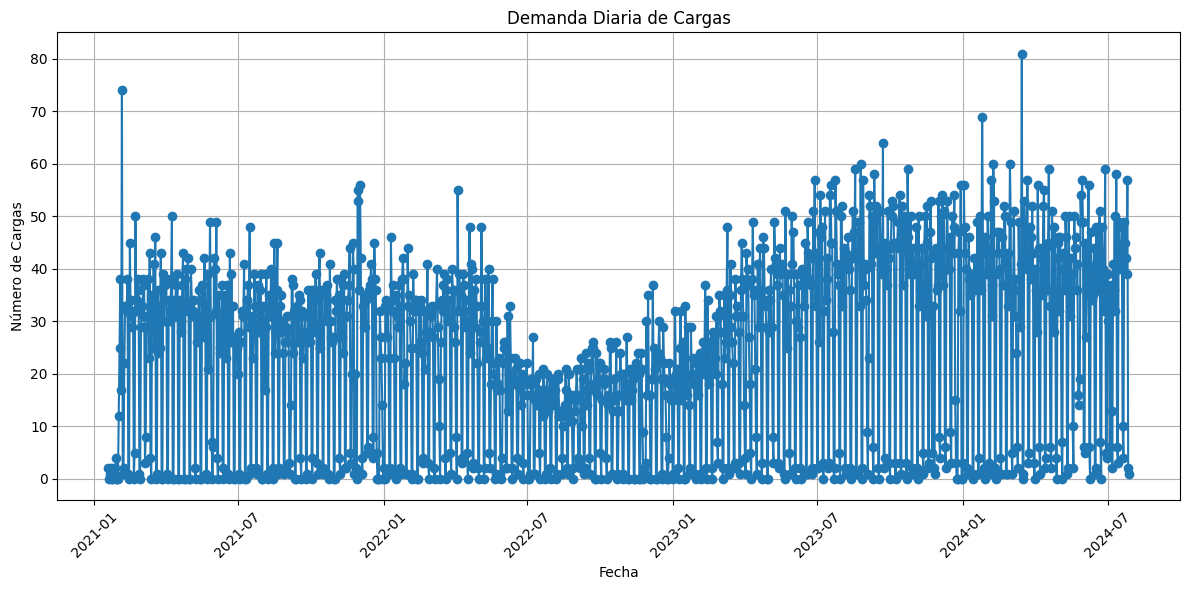

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Loads'], marker='o', linestyle='-')
plt.title('Demanda Diaria de Cargas')
plt.xlabel('Fecha')
plt.ylabel('Número de Cargas')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

De nuevo como hemos observado antes desde Julio de 2022, temporada en que se encontraba finalizando la pandemia, el valor que vienen recibiendo los carriers es cada vez menor, por esa misma razón distintas empresas han tenido que doblar su esfuerzo por cubrir más líneas y más cargas, aunque eso no necesariamente signifique más ingreso para la compañía.

In [9]:
series = df['Loads']
series = Series(series)
series.describe()

count    1287.000000
mean       24.182595
std        17.567601
min         0.000000
25%         4.000000
50%        27.000000
75%        38.000000
max        81.000000
Name: Loads, dtype: float64

La base de datos cuenta con 1,287 datos. En promedio, esta empresa transporta 24 cargas al día y ha tenido picos de trabajo donde incluso ha alcanzado a mover 81 cargas al día entre los disintos camiones con que cuenta.

In [20]:
ts = df['Loads']

## 2.1 Análisis de tendencia y estacionalidad en la serie de tiempo

### 2.1.1 Prueba de estacionariedad

Para la aplicación de modelos de tipo ARIMA, se trabaja sobre el supuesto de la estacionariedad de los datos, en donde la media y varianza de los datos permanece constante en el tiempo. Es importante garantizar este supuesto para poder aplicar este modelo. Para comprobar este supuesto tenemos tres opciones: Aplicar el análisis de la ACF y los estadísticos de Ljung-Box y Dickey Fuller. Desarrollemos esto a continuación:

<Figure size 550x550 with 0 Axes>

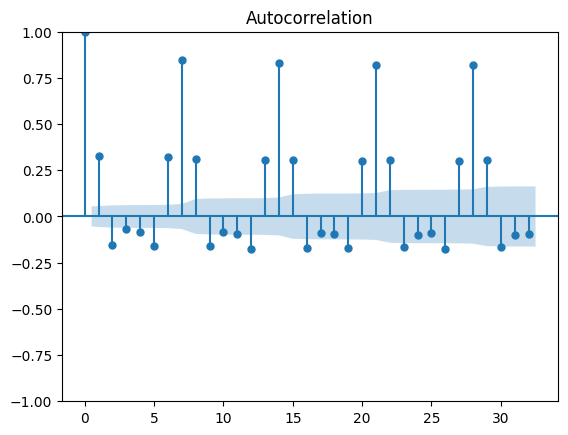

In [21]:
#gráfica ACF
plt.figure(figsize=(5.5, 5.5));
plot_acf(ts);

Existe autocorrelación parcial entre los retardos de la serie. De hecho, cada 7 observaciones tenemos un lag que sale de la barra de significancia, esto puede estar relacionado con el día domingo, entendiendo que es el día donde caen la cantidad de cargas transportadas por no ser día laboral. Las estacionalidades de la serie sobre todo, hacen que la serie no sea estacionaria.

In [27]:
#Independencia
#H0: Los datos son independientes
#H1: Los datos no son independientes    
ljung_box_test = acorr_ljungbox(ts, lags=10, return_df=True)
ljung_box_pvalue = ljung_box_test['lb_pvalue'].values[0]
    
if ljung_box_pvalue < 0.05:
    print("La serie no estacionaria, el p-valor de la prueba es", ljung_box_pvalue)

La serie no estacionaria, el p-valor de la prueba es 9.694090283997897e-32


De hecho si aplicamos la prueba de ljung-box el estadístico de prueba es bastante bajo lo que rechaza la hipótesis nula de independencia y nos lleva a afirmar que los datos son dependientes y que el comportamiento de observaciones pasadas me permiten predecir lo que ocurrirá mañana. Aspecto que ya hemos observado en la prueba ACF.

In [28]:
#H0: La serie no es estacionaria
#H1: La serie es estacionaria
adf_result = adfuller(df['Loads'], autolag='AIC')
if adf_result[1] > 0.05:
    print("La serie no estacionaria, el p-valor de la prueba es", adf_result[1])

La serie no estacionaria, el p-valor de la prueba es 0.3873366038215929


Sin embargo, podemos todavía más confirmar este análisis con la prueba de Dickey-fuller, que acepta la hipótesis nula de no estacionariedad.

Además de las estacionalidades diarias, existen otro tipo de comportamiento que como es de esperarse en una serie relacionada con demanda de cargas, hacen que la serie no sea estacionaria. Esto se puede deber a estacionalidades correspondientes a las estaciones del año y la aparición de cosechas, sobre todo en el caso de los camiones tipo 'reefer' que mueven cargas refrigeradas y que dependen de cosechas de frutas y verduras.

Por último, además, combinado con la estacionalidad, el factor de tendencia existe. Ya hemos explicado que la industria camionera requiere de mayor transporte de cargas para obtener el mismo nivel de ingreso que en otros años, por lo cual las cargas transportadas tienen tendencia al alza.

Todo esto influye en la no estacionariedad de la serie.

### 2.1.2. Descomposición de la serie de tiempo

Para hacer un análisis a profundidad de las componentes de estacionalidad y tendencia de la serie de tiempo podemos utilizar el módulo _seasonal_decompose_ de la librería stats.models de Python y hacer un análisis mensual de la información.

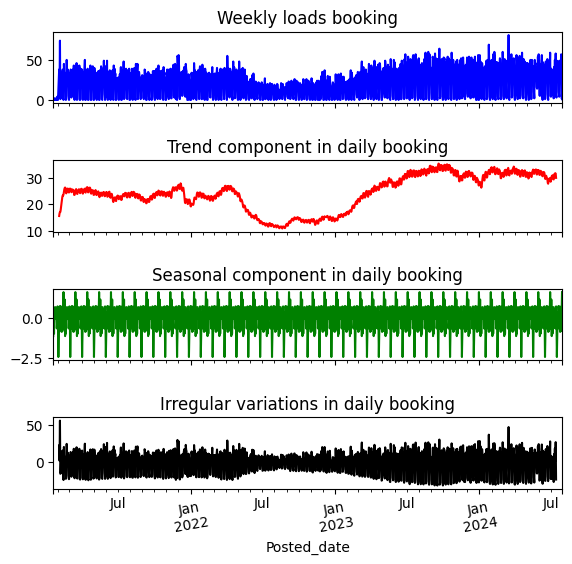

In [30]:
decompose_model = seasonal.seasonal_decompose(df.Loads.tolist(), period= 30, model='additive')

fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

df['Loads'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Weekly loads booking')

pd.Series(data=decompose_model.trend, index=df.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Trend component in daily booking')

pd.Series(data=decompose_model.seasonal, index=df.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Seasonal component in daily booking')

pd.Series(data=decompose_model.resid, index=df.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Irregular variations in daily booking')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0);
plt.xticks(rotation=10);

Se evidencia en esta descomposición la tendencia que tiene la serie de tiempo, sobre todo en los últimos dos años. Además existe mucho ruido afectando la serie de tiempo, lo que conocemos puede estar relacionado con la variabilidad de los datos durante los fines de semana con respecto a los días laborales.

### 2.1.3 Análisis de estacionalidad

Como la sospecha de estacionalidad es bastante alta, dada la naturaleza de la demanda y del comportamiento laboral del mercado, podemos hacer un análisis de cajas y bigotes en el tiempo que nos den un indicio de la variabilidad por ejemplo mensual de nuestra serie de tiempo, para observar si existen meses en los que patrones cíclicos se presenten.

In [57]:
df['Month'] = df['Posted_date'].dt.to_period('M').astype(str)
df['Week'] = df['Posted_date'].dt.to_period('W').astype(str)

In [58]:
stational=df.loc[(df['Posted_date']>'2023-12-30')]
stational.set_index('Posted_date', inplace=True)

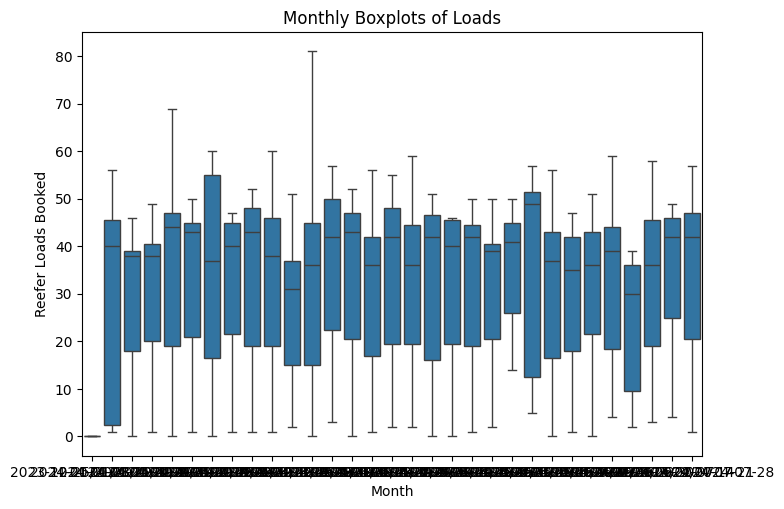

In [59]:
plt.figure(figsize=(8, 5.5))
g = sns.boxplot(stational, y='Loads', x='Week')
g.set_title('Monthly Boxplots of Loads')
g.set_xlabel('Month')
g.set_ylabel('Reefer Loads Booked');

En esta gráfica estamos observando semanalmente, cuantás cargas se pueden transportar por día en promedio. Existe alta variabilidad en los datos, los rangos intercuartílicos son muy pronunciados y además, en gran parte de los casos por semana se obtiene un valor mínimo cercano a cero, de nuevo relacionado con los domingos.

Esto también afecta la estacionariedad de la serie y disminuye su varianza constante en el tiempo, lo que puede generar posterior problemas en las pruebas de heterocedasticidad.

## 2.2 Diferenciación de la serie de tiempo

Para eliminar la raíz unitaria de la serie identificada con la prueba de Dickey-Fuller y el análisis exploratorio, debemos aplicar una diferenciación a la serie. Esto corresponde a la siguiente expresión:

$$x_t = y_t - y_{t-1} = \nabla y_t$$

In [61]:
df['Loads_diff']=df['Loads'].diff()

Conteniendo ya en nuestro dataframela serie diferenciada, el siguiente paso es aplicar una nueva prueba de Dickey-Fuller para comprobar si la serie es ahora estacionaria.

In [67]:
#H0: La serie no es estacionaria
#H1: La serie es estacionaria
adf_result = adfuller(df['Loads_diff'].dropna(), autolag='AIC')
if adf_result[1] < 0.05:
    print("La serie es estacionaria, el p-valor de la prueba es", adf_result[1])
if adf_result[1] > 0.05:
    print("La serie no estacionaria, el p-valor de la prueba es", adf_result[1])

La serie es estacionaria, el p-valor de la prueba es 1.0366841401724483e-20


A partir de la nueva prueba Dickey-Fuller realizada sobre la serie diferenciada, observamos que se rechaza la hipótesis nula de no estacionariedad. A partir de esto podemos confirmar que hemos eliminado la raíz unitaria de la serie y es ahora estacionaria.

Podemos graficar a continuación la comparación de cómo se ve nuestra serie antes y después de la diferenciación.

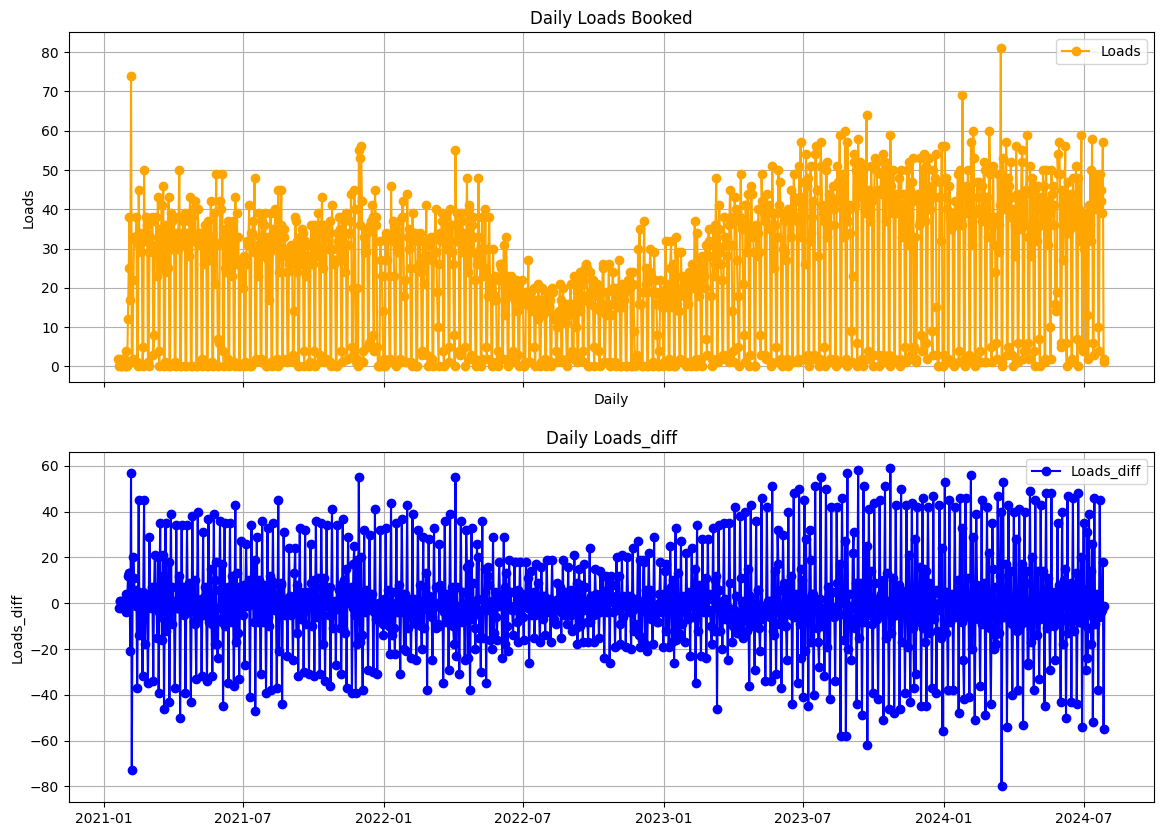

In [69]:
fig, (ax2, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

ax2.plot(df.index, df['Loads'], color='orange', label='Loads', marker='o')
ax2.set_title('Daily Loads Booked')
ax2.set_xlabel('Daily')
ax2.set_ylabel('Loads')
ax2.legend()
ax2.grid()

ax1.plot(df.index, df['Loads_diff'], color='blue', label='Loads_diff', marker='o')
ax1.set_title('Daily Loads_diff')
ax1.set_ylabel('Loads_diff')
ax1.legend()
ax1.grid()

A partir de este análisis ya conocemos para posterior creación de modelos ARIMA, la necesidad de establecer el parámetro _'d'_ como 1, aduciendo la necesidad de diferenciar la serie para poder generar el modelo.

## 3. Modelos de pronóstico

Continuemos entonces con la modulación de los modelos de pronóstico. Estaremos observando modelos de suavización de primer, segundo y tercer orden, modelos ARIMA, modelos SARIMA y modelos de redes neuronales.

Además, aplicaremos un último modelo mejorado para comparar su desempeño con respecto a estos modelos.